In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from hs2 import herdingspikes
from probe import NeuroPixel
from sklearn.cluster import DBSCAN

%matplotlib inline

In [2]:
# data = h5py.File(data_path, 'r')
# data = np.fromfile(data_path, dtype=np.int16).reshape((1800000,385))

Probe = NeuroPixel(fps=30000)
# Probe = BioCam()
H = herdingspikes(Probe)

In [3]:
# detectData(data, neighbours, spikefilename, shapefilename, channels, sfd, thres, maa = None, maxsl = None, minsl = None, ahpthr = None, tpre = 1, tpost = 2)
# MinAvgAmp minimal avg. amplitude of peak (in units of Qd)
# MaxSl dead time in frames after peak, used for further testing
# MinSl length considered for determining avg. spike amplitude
# AHPthr signal should go below that threshold within MaxSl-Slmin frames

# data_path = '/home/cole/neuropixeldata/rawDataSample.bin'

user = "Cole"

if user == "Hennig":
    data_path = '/disk/scratch/mhennig/neuropixel/data/rawDataSample.bin'
elif user == "Martino":
    #Martino's Data Path
    data_path = ""
else:
    data_path = '/home/cole/neuropixeldata/rawDataSample.bin'
    
to_localize = True
cutout_start = 10
cutout_end = 30
threshold = 12

In [4]:
H.DetectFromRaw(data_path,
                to_localize, cutout_start, cutout_end, threshold,
                maa=0, maxsl=12, minsl=3, ahpthr=0)

# # OR

# H.LoadDetected()

# Sampling rate: 30000
# Number of recorded channels: 385
# Analysing frames: 1800000, Seconds:60
# Frames before spike in cutout: 30
# Frames after spike in cutout: 66
# tcuts: 42 55
# tInc: 100000
# Analysing 100000 frames; -42 100055
# Analysing 100000 frames; 99958 200055
# Analysing 100000 frames; 199958 300055
# Analysing 100000 frames; 299958 400055
# Analysing 100000 frames; 399958 500055
# Analysing 100000 frames; 499958 600055
# Analysing 100000 frames; 599958 700055
# Analysing 100000 frames; 699958 800055
# Analysing 100000 frames; 799958 900055
# Analysing 100000 frames; 899958 1000055
# Analysing 100000 frames; 999958 1100055
# Analysing 100000 frames; 1099958 1200055
# Analysing 100000 frames; 1199958 1300055
# Analysing 100000 frames; 1299958 1400055
# Analysing 100000 frames; 1399958 1500055
# Analysing 100000 frames; 1499958 1600055
# Analysing 100000 frames; 1599958 1700055
# Analysing 99945 frames; 1699958 1800000
# Time taken for detection: 0:00:16.095818
# Time pe

('Spike detected at channel: ', 337)
('Spike detected at frame: ', 5187)


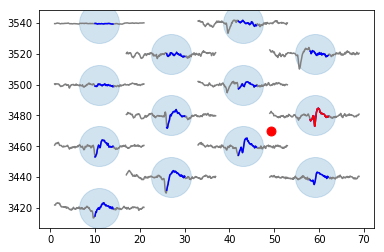

In [5]:
H.PlotTracesChannels(data_path, 1022)

In [ ]:
plt.figure(figsize=(12, 4))
H.PlotAll(invert=True, s=2, alpha=0.5)

In [ ]:
H.CombinedClustering(alpha=40,
                    bandwidth=20, bin_seeding=True, min_bin_freq=10,
                    pca_ncomponents=2, pca_whiten=True,
                    n_jobs=-1)

In [ ]:
plt.figure(figsize=(10, 5))
H.PlotAll(invert=True, s=10)
plt.xlim((1350,1600))
plt.title("MeanShift, bandwidth=20, min_bin_freq=10")

In [ ]:
H.CombinedClustering(eps=8, alpha=40, clustering_algorithm=DBSCAN,
                    min_samples=5, pca_ncomponents=2, pca_whiten=True,
                    n_jobs=-1)

In [ ]:
plt.figure(figsize=(10, 5))
H.PlotAll(invert=True, s=8)
plt.title("DBSCAN eps=8, min_samples=5")
plt.xlim((1350,1600))


In [ ]:
units = (121,4)

H.PlotShapes(units)